In [1]:
import sys
import pandas as pd
import sys
sys.path.append("../src")
from data_processing import DataLoader
from proxy_target import ProxyTargetEngineer 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

Load both the raw and feature engineered dataset.

In [3]:
raw_loader = DataLoader()
raw_data = raw_loader.load_data("../data/raw/data.csv")

processed_loader = DataLoader()
processed_data = processed_loader.load_data("../data/processed/feature_engineered_data.csv")

Initialize ProxyTargetEngineer

In [4]:
pte = ProxyTargetEngineer()

In [5]:
raw_data["TransactionStartTime"] = pd.to_datetime(
    raw_data["TransactionStartTime"], errors="coerce"
)

### Calculate RFM Metrics

- **Recency:** Days since the last transaction (calculated from a fixed snapshot date).  
- **Frequency:** Number of transactions per customer.  
- **Monetary:** Total amount spent by the customer.

In [6]:
# Compute RFM metrics
rfm = pte.compute_rfm(raw_data)
display(rfm.head())

print("\nRFM summary statistics:")
display(rfm.describe())


,CustomerId,recency,frequency,monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0



RFM summary statistics:


,recency,frequency,monetary
count,3742.000000,3742.000000,3.742000e+03
mean,31.461251,25.564404,1.717377e+05
std,27.118932,96.929602,2.717305e+06
min,1.000000,1.000000,-1.049000e+08
25%,6.000000,2.000000,4.077438e+03
50%,25.000000,7.000000,2.000000e+04
75%,54.000000,20.000000,7.996775e+04
max,91.000000,4091.000000,8.345124e+07


### Cluster Customers Using K-Means

Customers are segmented into 3 clusters based on their RFM profiles. 

- We use 3 clusters to separate high, medium, and low engagement customers.
- K-Means is scaled and has a fixed random_state for reproducibility.


In [7]:
rfm_clustered = pte.cluster_customers(rfm)
print("\nCluster distribution:")
display(rfm_clustered['cluster'].value_counts())



Cluster distribution:


cluster
2    2314
0    1427
1       1
Name: count, dtype: int64

### Define and Assign High-Risk Label

- Analyze clusters to identify the least engaged customers (typically low frequency and low monetary value).  
- Create a binary target `is_high_risk`:
    - `1` = high risk
    - `0` = low/medium risk


In [8]:
rfm_labeled = pte.assign_high_risk(rfm_clustered)
print("\nHigh-risk distribution")
display(rfm_labeled['is_high_risk'].value_counts())


High-risk distribution


is_high_risk
0    3741
1       1
Name: count, dtype: int64

Scatter plot of Frequency vs Monetary value colored by `is_high_risk`  
This confirms that high-risk customers are generally low frequency and low monetary.

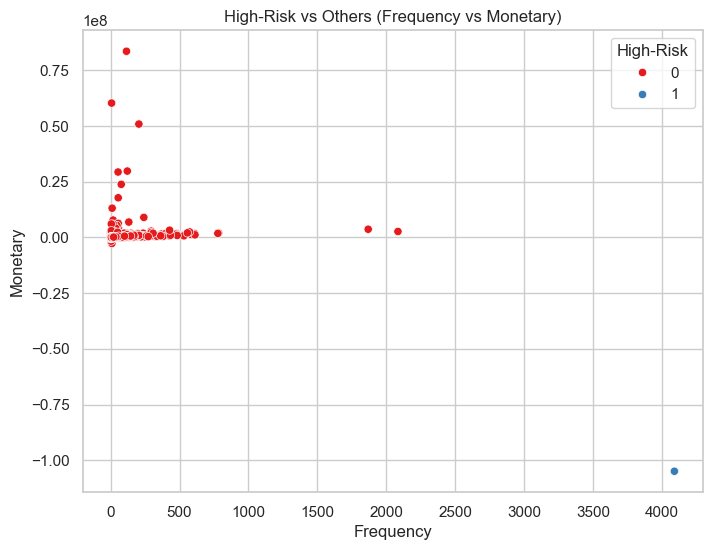

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm_labeled,
    x='frequency',
    y='monetary',
    hue='is_high_risk',
    palette='Set1'
)
plt.title("High-Risk vs Others (Frequency vs Monetary)")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.legend(title="High-Risk")
plt.show()  

### Merge Target Variable Back to Processed Data

The `is_high_risk` column is added to the customer-level feature-engineered dataset.  
This dataset is now ready for model training.


In [10]:
# Merge target back into processed dataset
final_df = pte.merge_target(processed_data, rfm_labeled)
print("\nFinal dataset head:")
display(final_df[['CustomerId','is_high_risk']].head())

print("\nCheck high-risk counts in final dataset:")
display(final_df['is_high_risk'].value_counts())

# Save final dataset
final_df.to_csv("../data/processed/feature_engineered_data_with_target.csv", index=False)



Final dataset head:


,CustomerId,is_high_risk
0,CustomerId_4406,0
1,CustomerId_4406,0
2,CustomerId_4683,0
3,CustomerId_988,0
4,CustomerId_988,0



Check high-risk counts in final dataset:


is_high_risk
0    91571
1     4091
Name: count, dtype: int64